<a href="https://colab.research.google.com/github/semaxspaul/semaxspaul_MalariaPrediction/blob/main/MalariaPrediction_semaxspaul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
(train_dataset, val_dataset, test_dataset), dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete2N0FXK/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Data Visualization

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

Data Preprocessing

In [ ]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [ ]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)
for image, label in train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Model Building

In [ ]:
from warnings import filters
model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, activation='relu', padding='valid'),
    MaxPooling2D(pool_size=2, strides=2),
    BatchNormalization(),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),

    Dense(10, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 16)        0         
 g2D)                                                            
                                                        

# Functional API

In [ ]:
from os import name
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name='Input Image')

mid_output = Conv2D(filters=6, kernel_size=3, strides=1, activation='relu', padding='valid')(func_input)
mid_output = BatchNormalization()(mid_output)
mid_output = MaxPooling2D(pool_size=2, strides=2)(mid_output)

mid_output = Conv2D(filters=16, kernel_size=3, strides=1, activation='relu', padding='valid')(mid_output)
mid_output = MaxPooling2D(pool_size=2, strides=2)(mid_output)
mid_output = BatchNormalization()(mid_output)

mid_output = Flatten()(mid_output)

mid_output = Dense(100, activation='relu')(mid_output)
mid_output = BatchNormalization()(mid_output)

mid_output = Dense(10, activation='relu')(mid_output)
mid_output = BatchNormalization()(mid_output)

func_output = Dense(1, activation='sigmoid')(mid_output)

func_model = Model(func_input, func_output, name='FunctionalMalariaModel')
func_model.summary()

Model: "FunctionalMalariaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 

In [ ]:
func_model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=BinaryCrossentropy(),
    metrics='accuracy'
)

In [ ]:
func_history = func_model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
689/689 [==============================] - 38s 52ms/step - loss: 0.2853 - accuracy: 0.8897 - val_loss: 0.4266 - val_accuracy: 0.9013
Epoch 2/20
689/689 [==============================] - 35s 51ms/step - loss: 0.1850 - accuracy: 0.9386 - val_loss: 0.1779 - val_accuracy: 0.9427
Epoch 3/20
689/689 [==============================] - 37s 54ms/step - loss: 0.1734 - accuracy: 0.9415 - val_loss: 0.3604 - val_accuracy: 0.8966
Epoch 4/20
689/689 [==============================] - 36s 52ms/step - loss: 0.1574 - accuracy: 0.9488 - val_loss: 0.8400 - val_accuracy: 0.5337
Epoch 5/20
689/689 [==============================] - 35s 50ms/step - loss: 0.1453 - accuracy: 0.9533 - val_loss: 0.4343 - val_accuracy: 0.8857
Epoch 6/20
689/689 [==============================] - 35s 51ms/step - loss: 0.1368 - accuracy: 0.9554 - val_loss: 0.2378 - val_accuracy: 0.9274
Epoch 7/20
689/689 [==============================] - 40s 58ms/step - loss: 0.1431 - accuracy: 0.9509 - val_loss: 0.1936 - val_accuracy:

# Model SubClassing

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, activation, padding, pool_size):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, activation=activation, padding=padding)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPooling2D(pool_size=pool_size, strides=2*strides)

    self.conv_2 = Conv2D(filters=filters+10, kernel_size=kernel_size, strides=strides, activation=activation, padding=padding)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPooling2D(pool_size=pool_size, strides=2*strides)

  def call(self, x, training):
    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(filters=6, kernel_size=3, strides=1, activation='relu', padding='valid', pool_size=2)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=BinaryCrossentropy(),
    metrics='accuracy'
)

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
689/689 [==============================] - 47s 54ms/step - loss: 0.3998 - accuracy: 0.8157 - val_loss: 0.2239 - val_accuracy: 0.9263
Epoch 2/20
689/689 [==============================] - 34s 50ms/step - loss: 0.1975 - accuracy: 0.9347 - val_loss: 0.4602 - val_accuracy: 0.8454
Epoch 3/20
689/689 [==============================] - 35s 51ms/step - loss: 0.1894 - accuracy: 0.9370 - val_loss: 0.2147 - val_accuracy: 0.9256
Epoch 4/20
689/689 [==============================] - 37s 54ms/step - loss: 0.1851 - accuracy: 0.9403 - val_loss: 0.4370 - val_accuracy: 0.6343
Epoch 5/20
689/689 [==============================] - 34s 50ms/step - loss: 0.1783 - accuracy: 0.9408 - val_loss: 0.4615 - val_accuracy: 0.6662
Epoch 6/20
689/689 [==============================] - 34s 50ms/step - loss: 0.1800 - accuracy: 0.9384 - val_loss: 0.5212 - val_accuracy: 0.6680
Epoch 7/20
689/689 [==============================] - 33s 47ms/step - loss: 0.1487 - accuracy: 0.9498 - val_loss: 0.5537 - val_accuracy:

In [ ]:
model.evaluate(train_dataset)

689/689 [==============================] - 37s 53ms/step - loss: 0.7829 - accuracy: 0.8839


[0.7829385995864868, 0.8838791847229004]

In [ ]:
def classification_function(prob_value):
  if prob_value < 0.5:
    return 'Inf'
  return 'Healthy'

In [ ]:
# Test Value
print(classification_function(model.predict(test_dataset.take(1))[0]))

1/1 [==============================] - 0s 102ms/step
Healthy


1/1 [==============================] - 0s 28ms/step


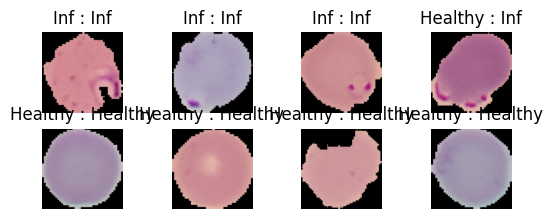

In [ ]:
for idx, (image, label) in enumerate(test_dataset.take(8)):

  ax2 = plt.subplot(4,4,idx+1)
  ax2.imshow(image[0])
  plt.title((classification_function(model.predict(image)[0]))+' : '+(classification_function(label.numpy()[0])))
  plt.axis('off')

In [ ]:
model.save('/content/drive/MyDrive/MalariaPrediction/semaxspaul_malariaPrediction')

In [ ]:
malariaModel = tf.keras.models.load_model('/content/drive/MyDrive/MalariaPrediction/semaxspaul_malariaPrediction')
malariaModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 16)        0         
 g2D)                                                            
                                                        

In [ ]:
model.save('/content/drive/MyDrive/MalariaPrediction/semaxspaul_malariaPrediction.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
